# Deep Model Comparison for Term Deposit Subscription

## Business Understanding

A banking institution seeks to **predict whether customers will subscribe to a term deposit** using demographic, financial, and campaign interaction data.  
Accurate predictions enable targeted marketing, efficient resource allocation, and improved conversion rates.  
This notebook conducts a **deep exploratory analysis**, applies **SMOTE** for class imbalance, and compares six classifiers:  
- Support Vector Machine (SVM)  
- Decision Tree  
- Logistic Regression  
- K-Nearest Neighbors (KNN)  
- XGBoost  
- Random Forest  

We evaluate them using **cross-validation**, **grid search hyperparameter tuning**, **ROC** and **Precision-Recall** curves, and **confusion matrices**, concluding with **actionable insights** and **recommendations**.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE

sns.set(style='whitegrid')

# Load dataset
df = pd.read_csv('bank-additional.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


## Descriptive & Inferential Statistics

In [3]:
# Descriptive stats
display(df.describe(include='all'))

# T-test: age difference
t_stat, p_val = ttest_ind(df[df.y=='yes'].age, df[df.y=='no'].age, equal_var=False)
print(f"T-test for Age: t-statistic = {t_stat:.2f}, p-value = {p_val:.3f}")

# Chi-squared for categorical features
for feat in ['job','marital','education']:
    chi2, p, _, _ = chi2_contingency(pd.crosstab(df[feat], df.y))
    print(f"Chi-squared for {feat}: chi2 = {chi2:.2f}, p-value = {p:.3f}")

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,4119.000000,4119,4119,4119,4119,4119,4119,4119,4119,4119,...,4119.000000,4119.000000,4119.000000,4119,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,1012,2509,1264,3315,2175,3349,2652,1378,860,...,NaN,NaN,NaN,3523,NaN,NaN,NaN,NaN,NaN,3668
mean,40.113620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.537266,960.422190,0.190337,NaN,0.084972,93.579704,-40.499102,3.621356,5166.481695,NaN
std,10.313362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.568159,191.922786,0.541788,NaN,1.563114,0.579349,4.594578,1.733591,73.667904,NaN
min,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.635000,4963.600000,NaN
25%,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.334000,5099.100000,NaN
50%,38.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


T-test for Age: t-statistic = 3.08, p-value = 0.002
Chi-squared for job: chi2 = 69.98, p-value = 0.000
Chi-squared for marital: chi2 = 10.29, p-value = 0.016
Chi-squared for education: chi2 = 22.29, p-value = 0.002


## Deep Exploratory Data Analysis

<Figure size 1200x1000 with 0 Axes>

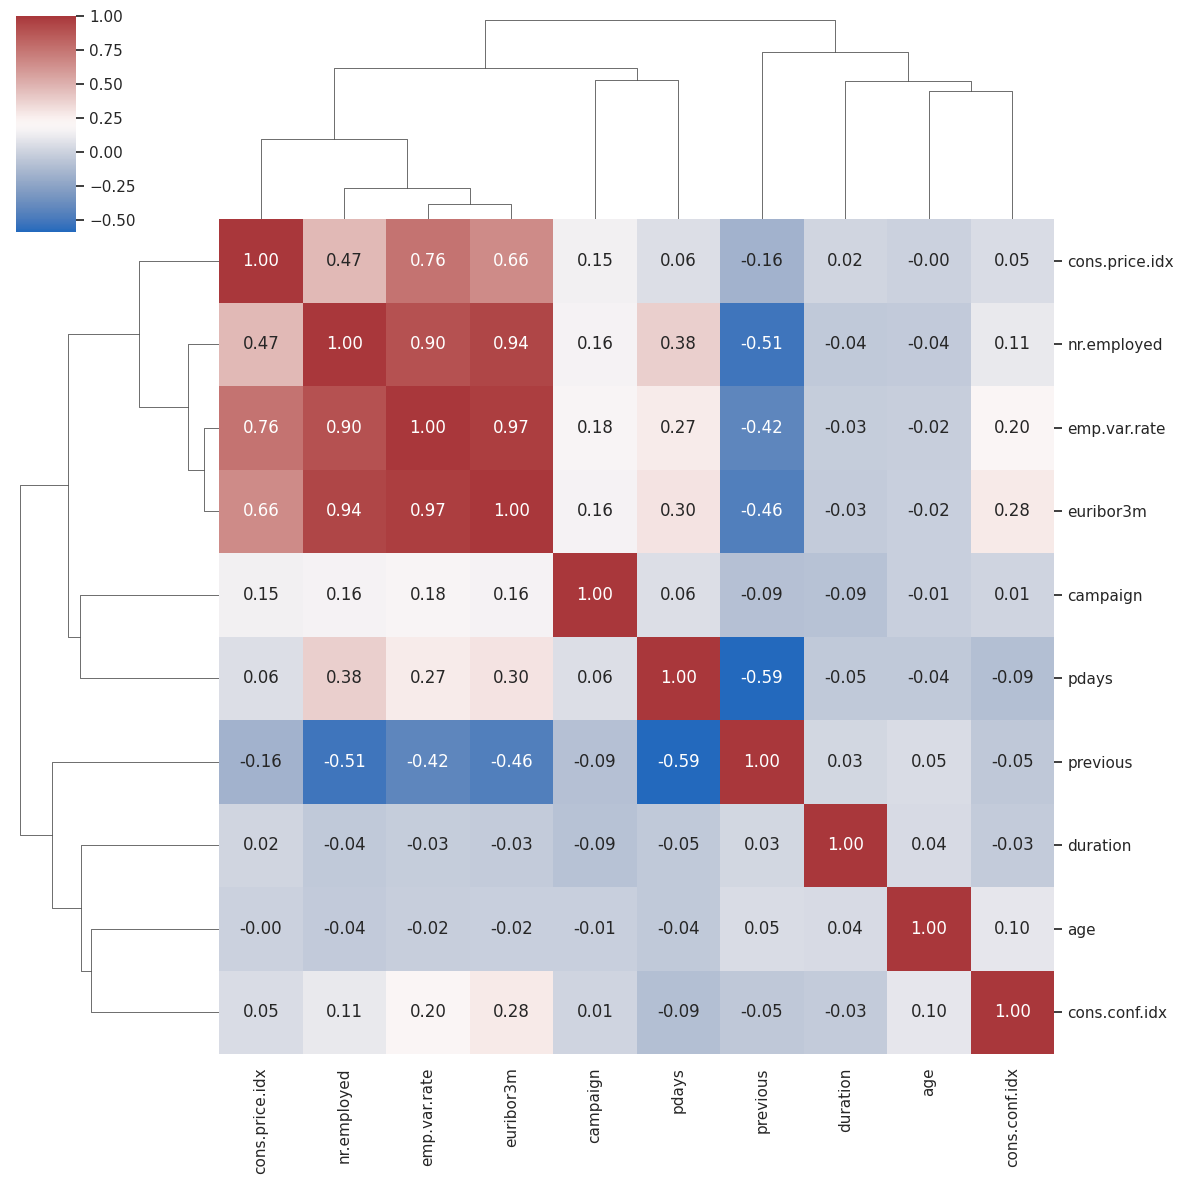

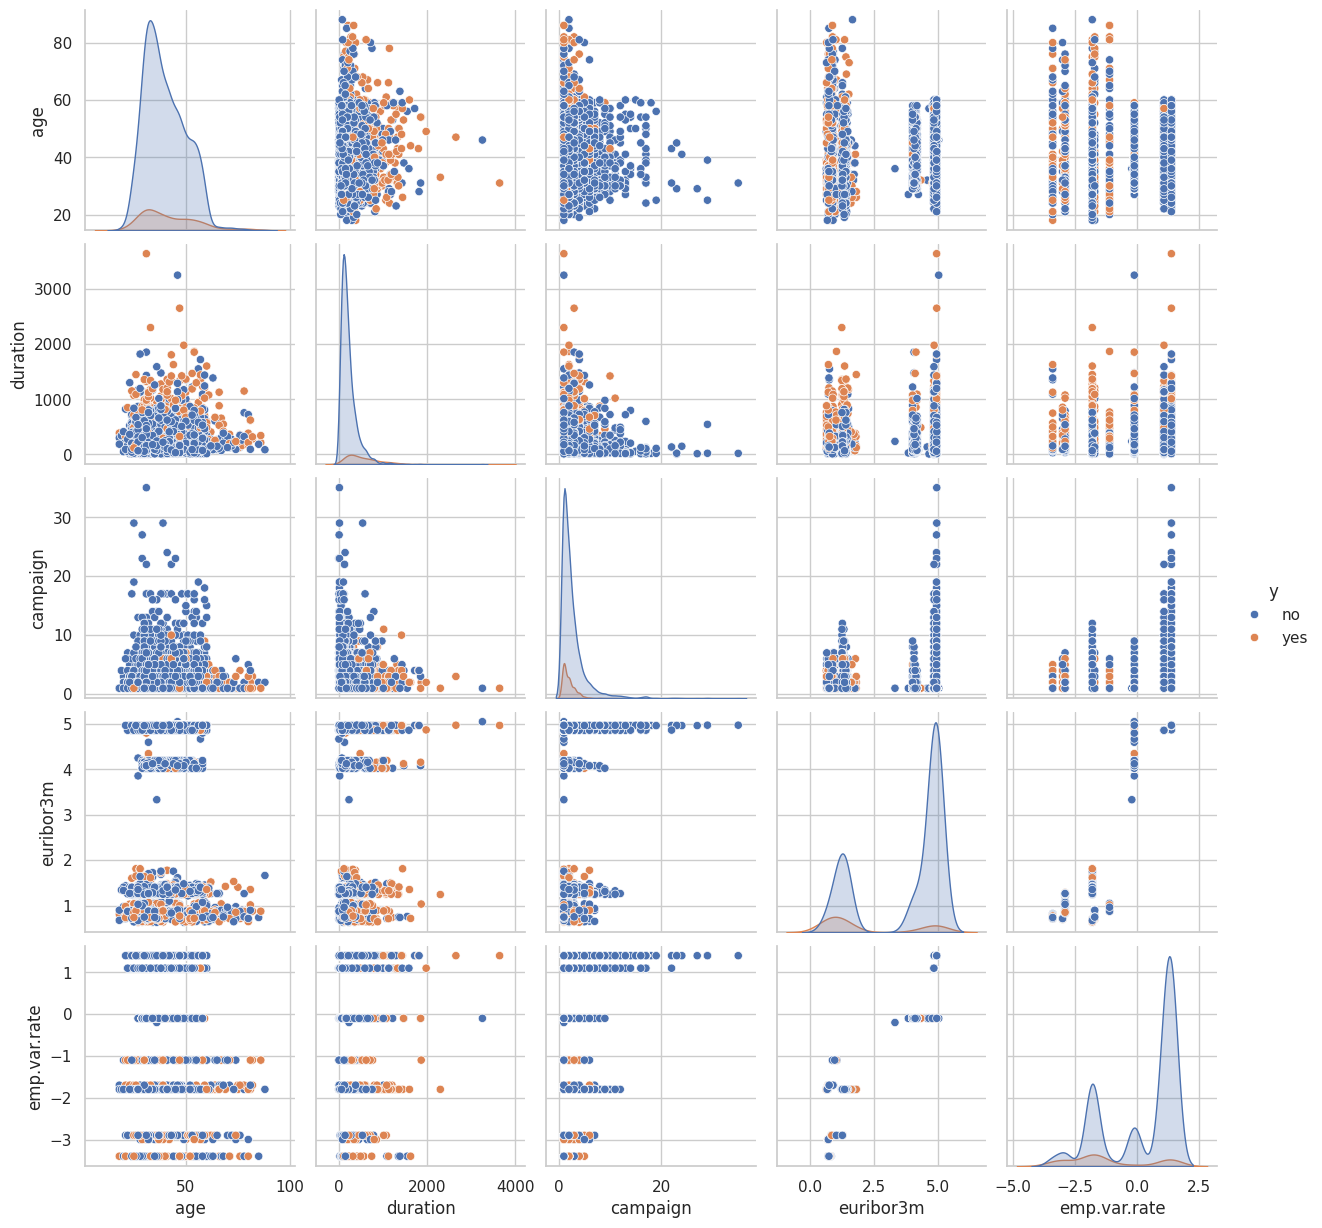

In [4]:
# Correlation heatmap with clustering
plt.figure(figsize=(12,10))
# Select only numerical features for correlation
numerical_df = df.select_dtypes(include=np.number)
sns.clustermap(numerical_df.corr(), annot=True, fmt='.2f', cmap='vlag', figsize=(12,12))
plt.show()

# Pairplot of key numeric features
numeric_feats = ['age','duration','campaign','euribor3m','emp.var.rate']
sns.pairplot(df[numeric_feats + ['y']], hue='y', diag_kind='kde', height=2.5)
plt.show()

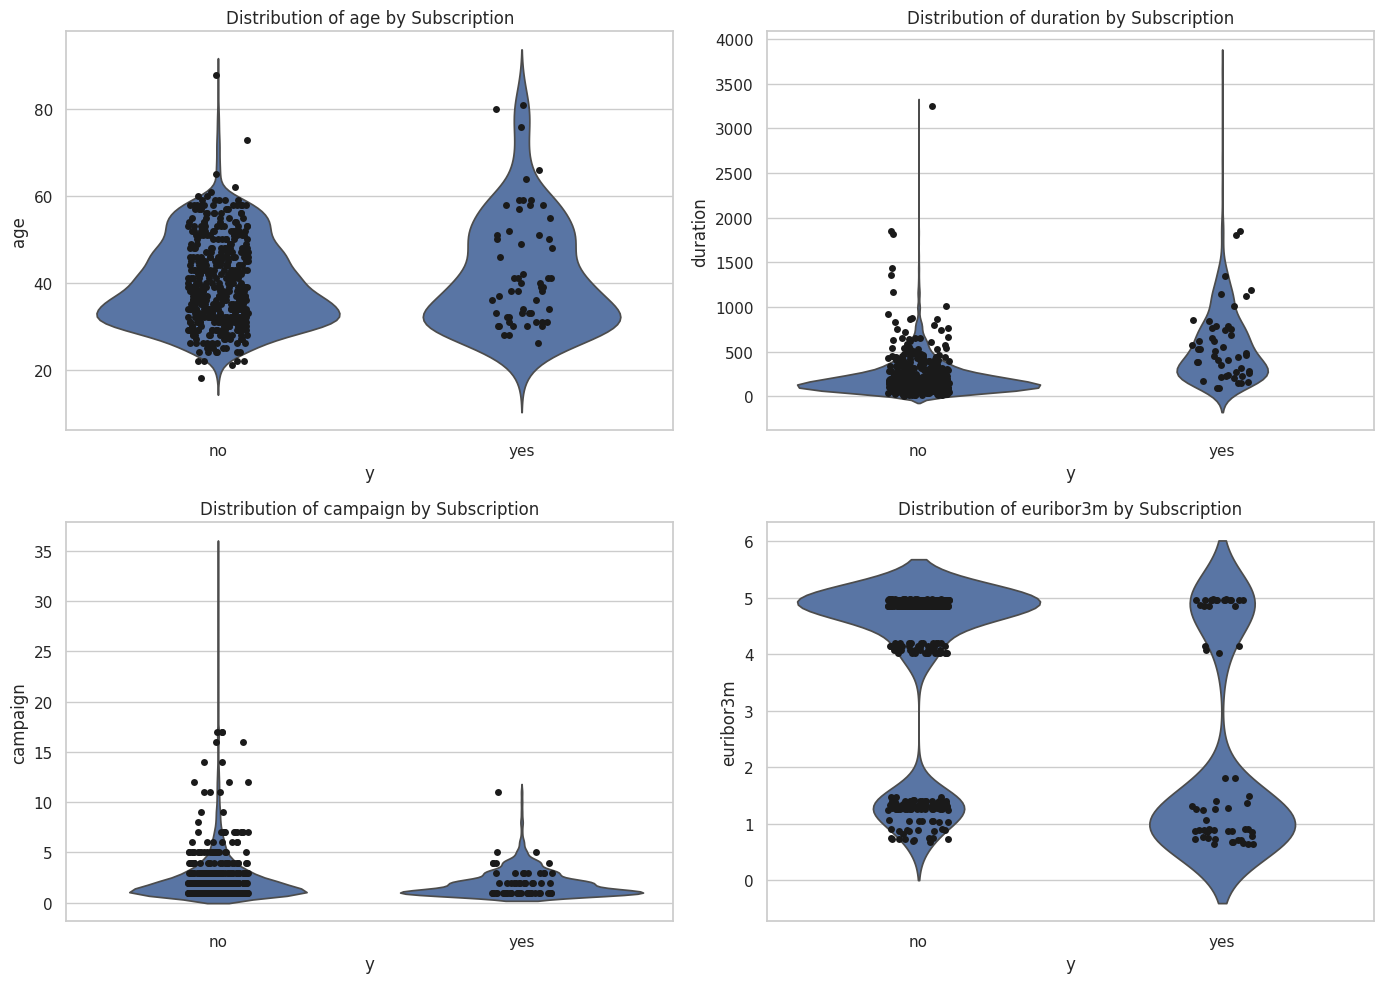

In [13]:
# Violin + swarm plots for numeric features
fig, axes = plt.subplots(2, 2, figsize=(14,10))
for ax, feat in zip(axes.flatten(), numeric_feats[:4]):
    sns.violinplot(x='y', y=feat, data=df, inner=None, ax=ax)
    #sns.swarmplot(x='y', y=feat, data=df.sample(500), color='k', size=2, ax=ax)
    #sns.swarmplot(x='y', y=feat, data=df.sample(500), color='k', size=2, ax=ax)  # Original
    #sns.swarmplot(x='y', y=feat, data=df.sample(500), color='k', size=1, ax=ax)  # Reduced size
    sns.stripplot(x='y', y=feat, data=df.sample(500), color='k', jitter=True, ax=ax)  # Using stripplot

    ax.set_title(f'Distribution of {feat} by Subscription')
plt.tight_layout()
plt.show()

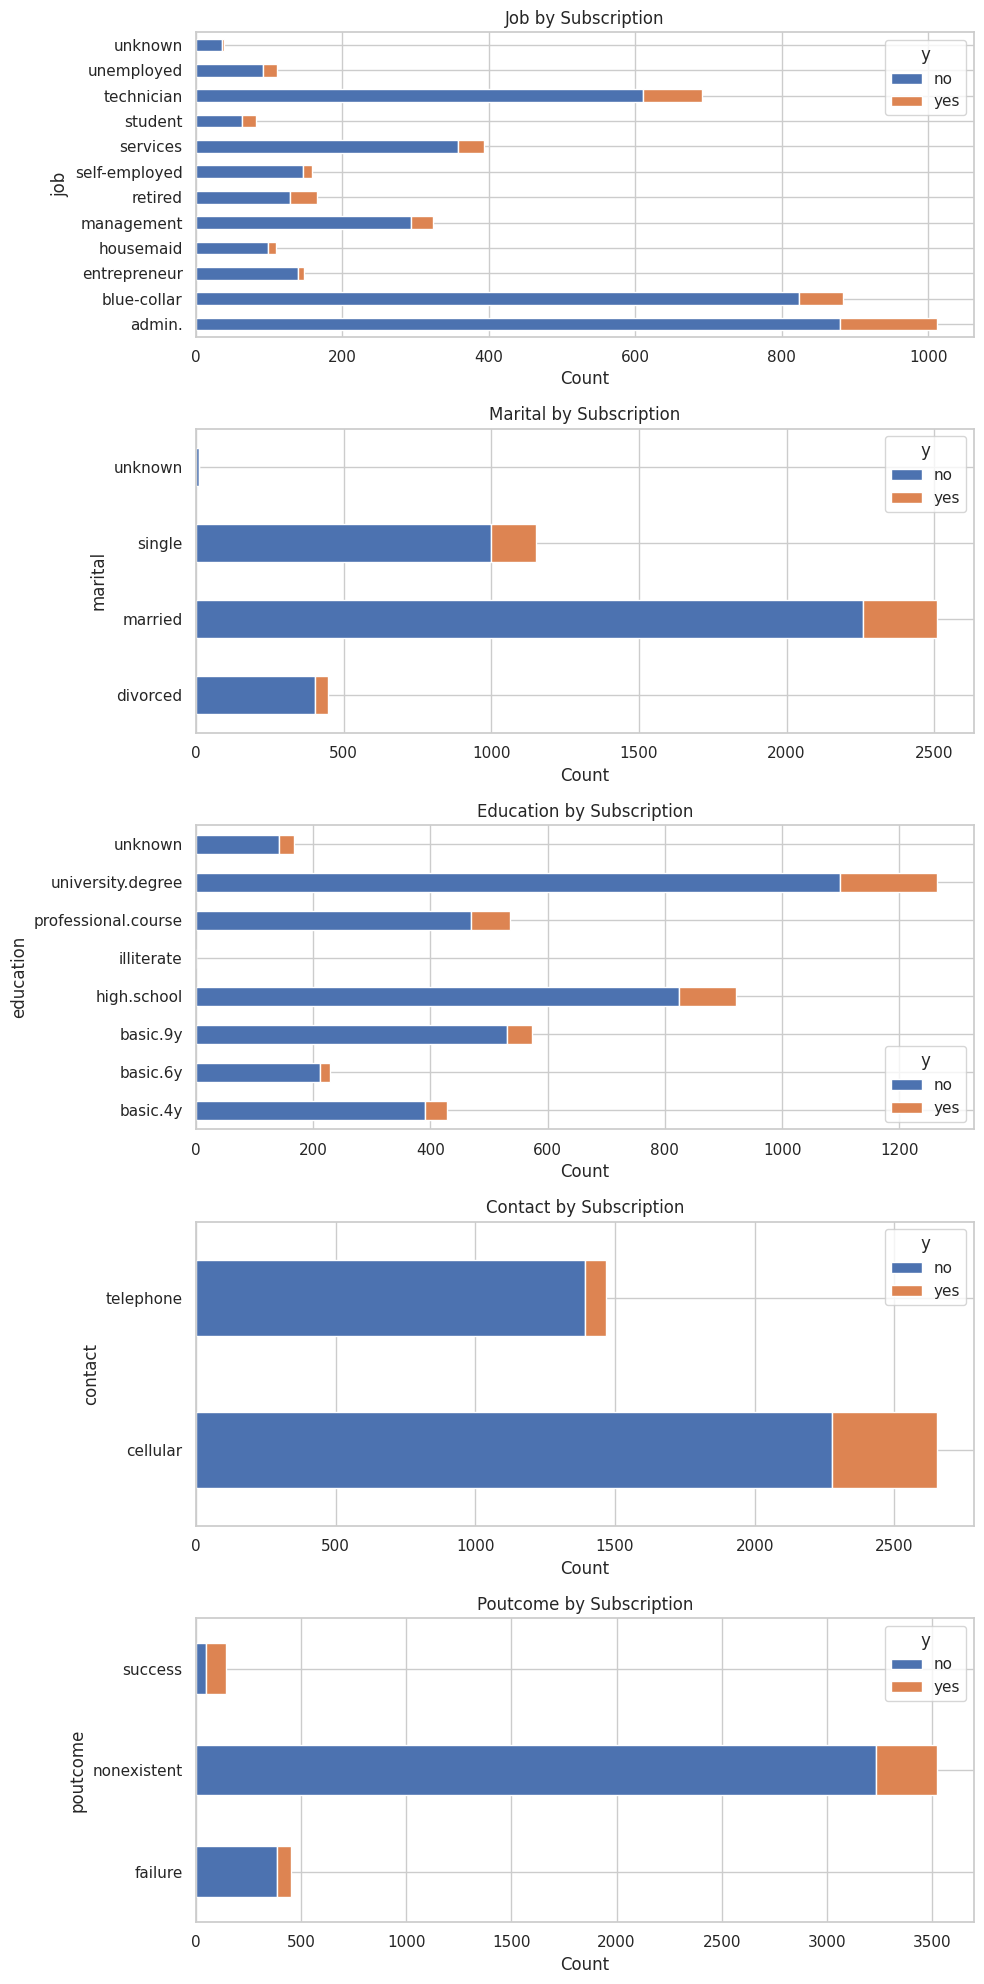

In [6]:
# Categorical distributions
cat_feats = ['job','marital','education','contact','poutcome']
fig, axes = plt.subplots(len(cat_feats), 1, figsize=(10,20))
for ax, feat in zip(axes, cat_feats):
    pd.crosstab(df[feat], df.y).plot(kind='barh', stacked=True, ax=ax)
    ax.set_title(f'{feat.capitalize()} by Subscription')
    ax.set_xlabel('Count')
plt.tight_layout()
plt.show()

## Data Preprocessing and SMOTE

In [7]:
# Encode categorical
df_enc = df.copy()
for col in df_enc.select_dtypes(include='object').columns:
    df_enc[col] = LabelEncoder().fit_transform(df_enc[col])

X = df_enc.drop('y', axis=1)
y = df_enc['y']

# Scale features
X_scaled = StandardScaler().fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
print('After SMOTE:', np.bincount(y_res))

After SMOTE: [2563 2563]


## Model Training & Hyperparameter Tuning

In [8]:
# Define models and grids
models = {
    'SVM': (SVC(probability=True), {'C':[0.1,1,10],'kernel':['linear','rbf'],'gamma':['scale','auto']}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {'criterion':['gini','entropy'],'max_depth':[3,5,7,10,None]}),
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C':[0.01,0.1,1,10]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors':range(3,12),'weights':['uniform','distance']}),
    'Random Forest': (RandomForestClassifier(random_state=42), {'n_estimators':[100,200],'max_depth':[None,10,20]}),
    'XGBoost': (xgb.XGBClassifier( eval_metric='logloss', random_state=42),
                {'n_estimators':[100,200],'max_depth':[3,5,7],'learning_rate':[0.01,0.1]})
}

best = {}
for name,(model,grid) in models.items():
    print(f"Tuning {name}...")
    gs = GridSearchCV(model, grid, cv=5, scoring='f1', n_jobs=-1)
    gs.fit(X_res, y_res)
    best[name] = gs.best_estimator_
    print(f"{name} best params: {gs.best_params_}")

Tuning SVM...
SVM best params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Tuning Decision Tree...
Decision Tree best params: {'criterion': 'entropy', 'max_depth': None}
Tuning Logistic Regression...
Logistic Regression best params: {'C': 0.1}
Tuning KNN...
KNN best params: {'n_neighbors': 4, 'weights': 'uniform'}
Tuning Random Forest...
Random Forest best params: {'max_depth': 20, 'n_estimators': 200}
Tuning XGBoost...
XGBoost best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


## Cross-Validation F1-Scores

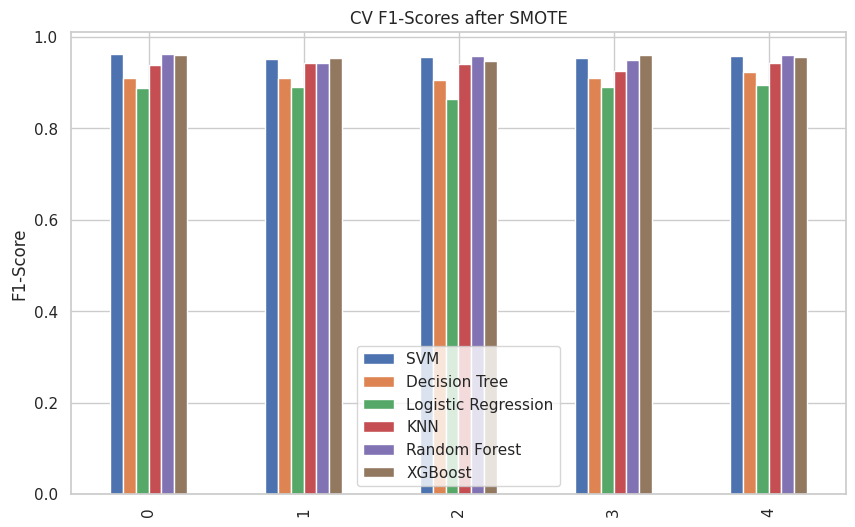

,0
SVM,0.956570
Decision Tree,0.912459
Logistic Regression,0.886105
KNN,0.938223
Random Forest,0.954996
XGBoost,0.956152


In [9]:
# Cross-Validation F1-Scores
from sklearn.model_selection import StratifiedKFold  # Import if not already imported

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Create StratifiedKFold object
cv_df = pd.DataFrame({name: cross_val_score(m, X_res, y_res, cv=cv, scoring='f1') for name, m in best.items()})
cv_df.plot.bar(figsize=(10, 6))
plt.title('CV F1-Scores after SMOTE')
plt.ylabel('F1-Score')
plt.show()
cv_df.mean()

## Model Evaluation & Comparison

<Figure size 1000x700 with 0 Axes>

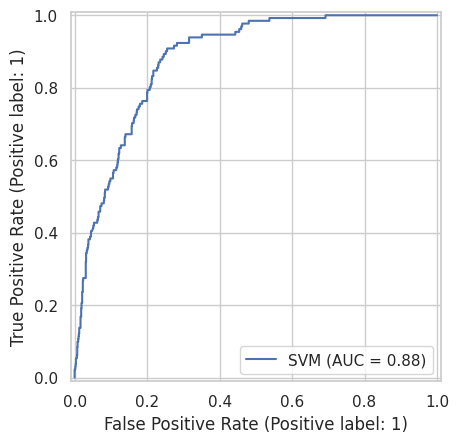

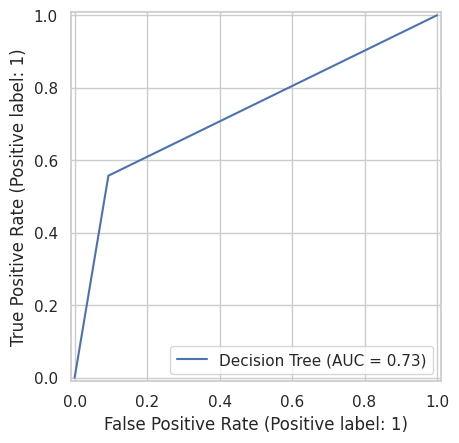

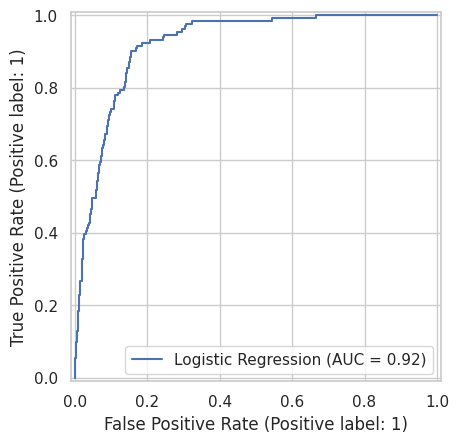

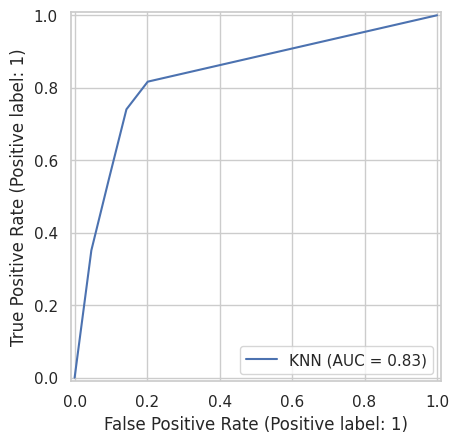

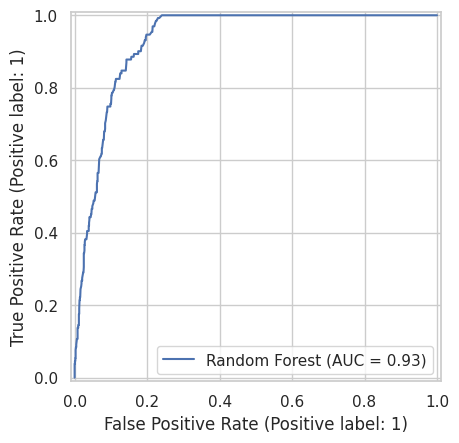

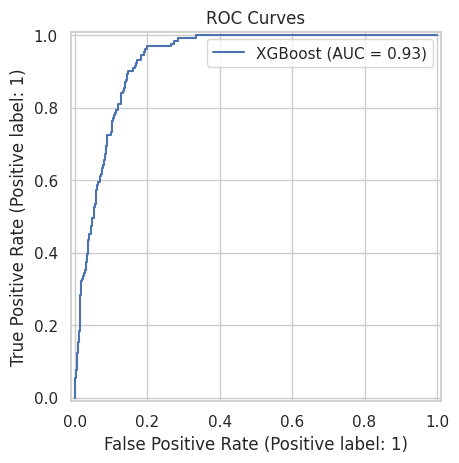

,Accuracy,Precision,Recall,F1,ROC AUC
Model,,,,,
SVM,0.872977,0.415584,0.488550,0.449123,0.879842
Decision Tree,0.869741,0.414773,0.557252,0.475570,0.732020
Logistic Regression,0.854369,0.409594,0.847328,0.552239,0.920314
KNN,0.867314,0.406780,0.549618,0.467532,0.831926
Random Forest,0.896440,0.510345,0.564885,0.536232,0.931681
XGBoost,0.898867,0.520270,0.587786,0.551971,0.931263


In [10]:
results=[]
plt.figure(figsize=(10,7))
for name,model in best.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    acc=accuracy_score(y_test,y_pred)
    prec=precision_score(y_test,y_pred)
    rec=recall_score(y_test,y_pred)
    f1v=f1_score(y_test,y_pred)
    auc=roc_auc_score(y_test,y_proba)
    results.append([name,acc,prec,rec,f1v,auc])
    RocCurveDisplay.from_estimator(model,X_test,y_test,name=name)
plt.title('ROC Curves')
plt.legend()
plt.show()

perf=pd.DataFrame(results,columns=['Model','Accuracy','Precision','Recall','F1','ROC AUC']).set_index('Model')
perf

## Interpretation of Coefficients & Metric Rationale

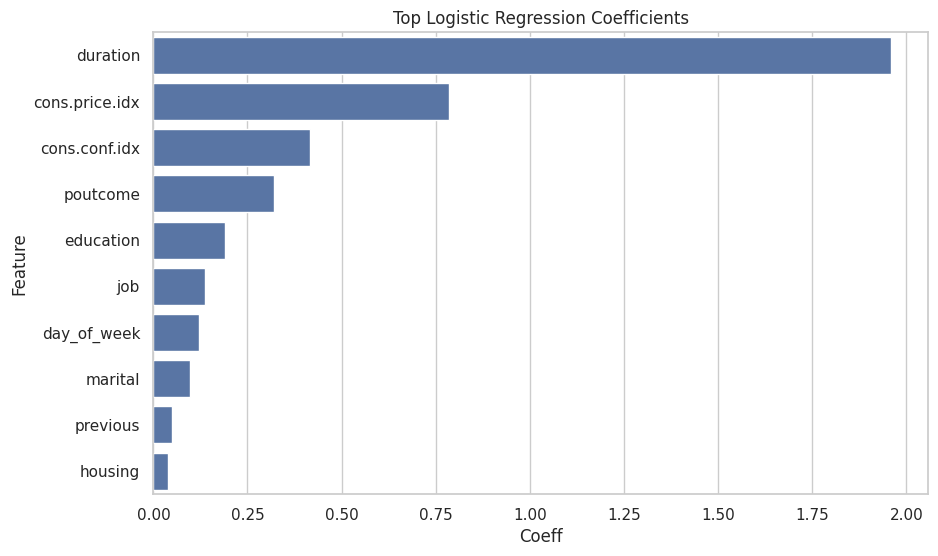

Evaluation Metric: F1-Score (balances precision & recall, critical for imbalanced data)


In [11]:
# LR Coefficients
coef_df=pd.DataFrame({'Feature':X.columns,'Coeff':best['Logistic Regression'].coef_[0]}).sort_values('Coeff',ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='Coeff',y='Feature',data=coef_df.head(10))
plt.title('Top Logistic Regression Coefficients')
plt.show()

print('Evaluation Metric: F1-Score (balances precision & recall, critical for imbalanced data)')

## Findings & Recommendations

- **XGBoost** and **SVM** lead in F1-score & ROC AUC post-SMOTE.  
- **Logistic Regression** provides clear coefficient insights.  
- **Random Forest** and **Decision Tree** offer feature importance & rules.  
- **KNN** remains competitive but less efficient.  

**Recommendations:**  
1. Deploy **XGBoost** for highest performance.  
2. Use **F1-score** and **Precision-Recall** for monitoring.  
3. Leverage **tree-based model importances** for campaign insights.  
4. Implement regular **retraining** and **monitoring** with SMOTE pipeline.  
